In [32]:
# https://youtu.be/0W6MKZqSke8
"""
Author: Dr. Sreenivas Bhattiprolu 

This code can be used to perform semantic segmentation of aerial / satellite 
images, especially the dataset from landcover.ai

Dataset from : https://landcover.ai/
Dataset description: https://arxiv.org/pdf/2005.02264.pdf

Link doesn't seem to work anymore: Try this one instead: https://landcover.ai.linuxpolska.com/

labels:
    0: Unlabeled background 
    1: Buildings
    2: Woodlands
    3: Water

You can use any U-net but this code demonstrates the use of pretrained encoder 
in the U-net - available as part of segmentation models library. 

To install the segmentation models library: pip install -U segmentation-models
If you are running into generic_utils error when loading segmentation models library
watch this video to fix it: https://youtu.be/syJZxDtLujs

Use the landcover_prepare_data.py to prepare your data. 
e.g., divide images to smaller patches, svae only the patches with real labels, split to train and val. 



"""

import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
import random

# tf.compat.v1.disable_eager_execution() #in case the model gets very slow, may be due to a bug in TF2.0. Uncomment this. 
#https://github.com/tensorflow/tensorflow/issues/33024

#Also check this in case you notice training to be getting increasingly slow each epoch.
# https://stackoverflow.com/questions/53683164/keras-occupies-an-indefinitely-increasing-amount-of-memory-for-each-epoch


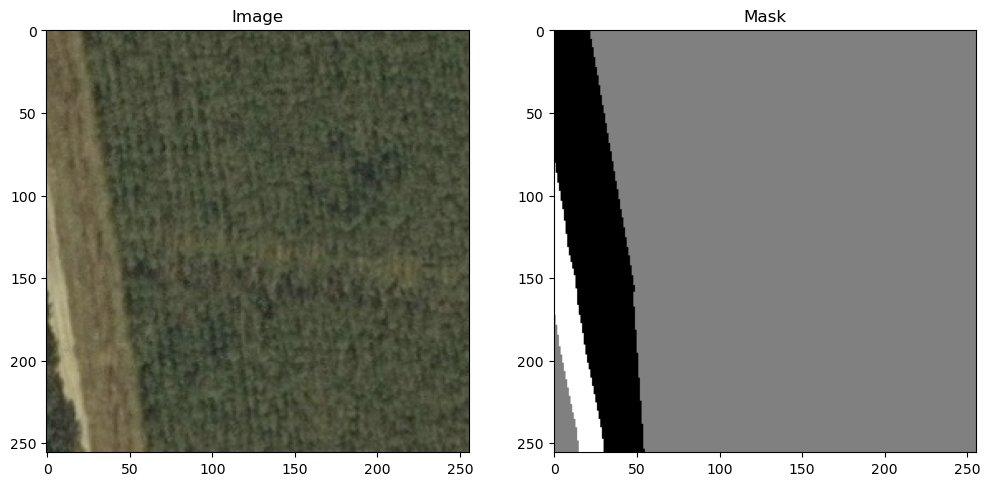

In [33]:
#Get an understanding by looking at a few random images and masks 
import random
import cv2
import matplotlib.pyplot as plt
train_img_dir = "C:\\Users\\abc\\Downloads\\python\\landcover for project\\patches\\images_with_useful_info\\images\\train\\"
train_mask_dir = "C:\\Users\\abc\\Downloads\\python\\landcover for project\\patches\\images_with_useful_info\\masks\\train\\"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))


img_num = random.randint(0, num_images-1)

img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)
img_for_plot_rgb = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot =cv2.imread(train_mask_dir+msk_list[img_num], 0)

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()

In [102]:
# # Define Generator for images and masks so we can read them directly from the drive. 
# batch_size = 32
# seed = 42

seed=24
batch_size= 16
n_classes=5

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from keras.utils import to_categorical

#Use this to preprocess input for transfer learning
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

#Define a function to perform additional preprocessing after datagen.
#For example, scale images, convert masks to categorical, etc. 

In [103]:
def preprocess_data(img, mask, num_class):
    #Scale images
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    img = preprocess_input(img)  #Preprocess based on the pretrained backbone...
    #Convert mask to one-hot
    mask = to_categorical(mask, num_class)
      
    return (img,mask)

In [107]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def trainGenerator(train_img_path, train_mask_path, num_class):
    
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)
    
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        color_mode = 'grayscale',
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)



        
        
        
        
        
train_img_path ="C:\\Users\\abc\\Downloads\\python\\landcover for project\\patches\\images_with_useful_info\\itr\\"
train_mask_path ="C:\\Users\\abc\\Downloads\\python\\landcover for project\\patches\\images_with_useful_info\\mtr\\"
train_img_gen = trainGenerator(train_img_path, train_mask_path, num_class=5)

val_img_path = "C:\\Users\\abc\\Downloads\\python\\landcover for project\\patches\\images_with_useful_info\\its\\"
val_mask_path = "C:\\Users\\abc\\Downloads\\python\\landcover for project\\patches\\images_with_useful_info\\mts\\"
val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=5)
# # x, y = train_img_gen.__next__()
# # x, y = next(train_img_gen)
# for i in range(0,4):
#     image = x[i]
#     mask = np.argmax(y[i], axis=2)
#     plt.subplot(1,2,1)
#     plt.imshow(image)
#     plt.subplot(1,2,2)
#     plt.imshow(mask, cmap='gray')
#     plt.show()
    

Found 1046 images belonging to 1 classes.
Found 1046 images belonging to 1 classes.


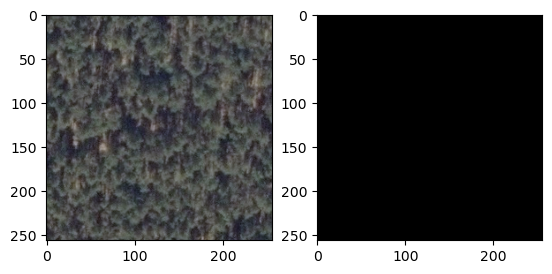

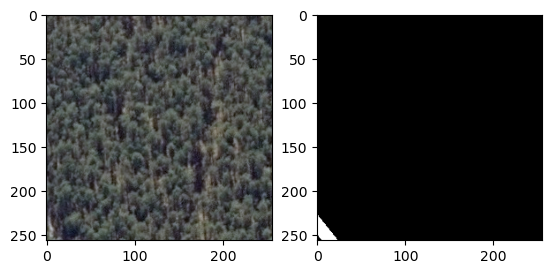

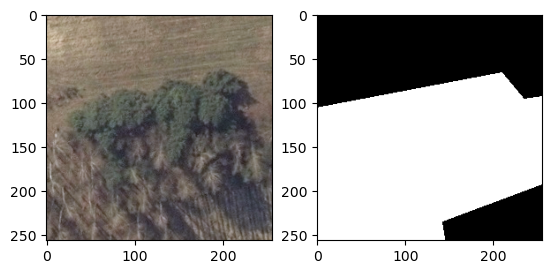

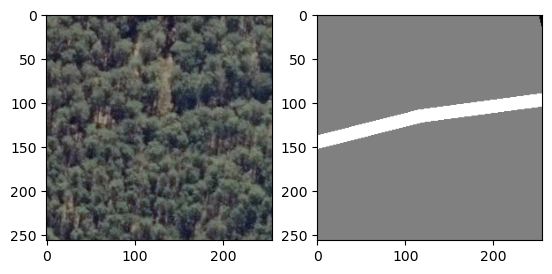

In [108]:



x, y = train_img_gen.__next__()
# x, y = next(train_img_gen)
for i in range(0,4):
    image = x[i]
    mask = np.argmax(y[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()



Found 386 images belonging to 1 classes.
Found 386 images belonging to 1 classes.


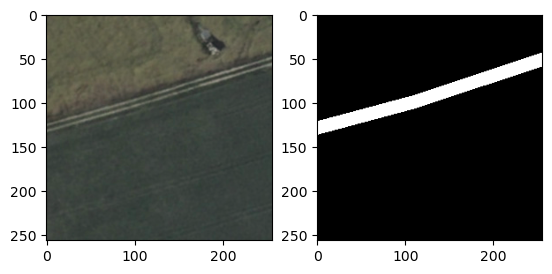

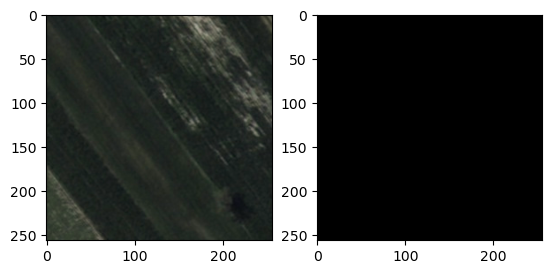

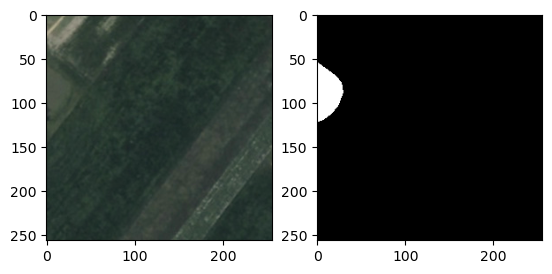

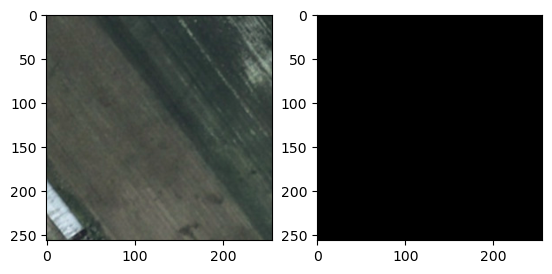

In [109]:
x_val, y_val = val_img_gen.__next__()

for i in range(0,4):
    image = x_val[i]
    mask = np.argmax(y_val[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()


In [110]:
#Define the model metrcis and load model. 

num_train_imgs = len(os.listdir('C:\\Users\\abc\\Downloads\\python\\landcover for project\\patches\\images_with_useful_info\\itr\\imagestrain\\'))
num_val_images = len(os.listdir('C:\\Users\\abc\\Downloads\\python\\landcover for project\\patches\\images_with_useful_info\\its\\imagestest\\'))
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size


IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]

n_classes=5

In [100]:
#Use transfer learning using pretrained encoder in the U-Net
#(make sure you uncomment the preprocess_input part in the
# preprocess_data function above)
################################################################
#Define the model
# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                classes=n_classes, activation='softmax')
model.compile('Adam', loss=sm.losses.categorical_focal_jaccard_loss, metrics=[sm.metrics.iou_score])

#Other losses to try: categorical_focal_dice_loss, cce_jaccard_loss, cce_dice_loss, categorical_focal_loss

#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
print(model.summary())
print(model.input_shape)
#Fit the model

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, 256, 256, 3)          9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d_102 (ZeroPa  (None, 262, 262, 3)          0         ['bn_data[0][0]']             
 dding2D)                                                                                         
                                                                                            

                                                                                                  
 zero_padding2d_108 (ZeroPa  (None, 66, 66, 64)           0         ['stage1_unit3_relu1[0][0]']  
 dding2D)                                                                                         
                                                                                                  
 stage1_unit3_conv1 (Conv2D  (None, 64, 64, 64)           36864     ['zero_padding2d_108[0][0]']  
 )                                                                                                
                                                                                                  
 stage1_unit3_bn2 (BatchNor  (None, 64, 64, 64)           256       ['stage1_unit3_conv1[0][0]']  
 malization)                                                                                      
                                                                                                  
 stage1_un

                                                                                                  
 zero_padding2d_114 (ZeroPa  (None, 34, 34, 128)          0         ['stage2_unit3_relu1[0][0]']  
 dding2D)                                                                                         
                                                                                                  
 stage2_unit3_conv1 (Conv2D  (None, 32, 32, 128)          147456    ['zero_padding2d_114[0][0]']  
 )                                                                                                
                                                                                                  
 stage2_unit3_bn2 (BatchNor  (None, 32, 32, 128)          512       ['stage2_unit3_conv1[0][0]']  
 malization)                                                                                      
                                                                                                  
 stage2_un

                                                                                                  
 zero_padding2d_120 (ZeroPa  (None, 18, 18, 256)          0         ['stage3_unit2_relu1[0][0]']  
 dding2D)                                                                                         
                                                                                                  
 stage3_unit2_conv1 (Conv2D  (None, 16, 16, 256)          589824    ['zero_padding2d_120[0][0]']  
 )                                                                                                
                                                                                                  
 stage3_unit2_bn2 (BatchNor  (None, 16, 16, 256)          1024      ['stage3_unit2_conv1[0][0]']  
 malization)                                                                                      
                                                                                                  
 stage3_un

 dding2D)                                                                                         
                                                                                                  
 stage3_unit5_conv1 (Conv2D  (None, 16, 16, 256)          589824    ['zero_padding2d_126[0][0]']  
 )                                                                                                
                                                                                                  
 stage3_unit5_bn2 (BatchNor  (None, 16, 16, 256)          1024      ['stage3_unit5_conv1[0][0]']  
 malization)                                                                                      
                                                                                                  
 stage3_unit5_relu2 (Activa  (None, 16, 16, 256)          0         ['stage3_unit5_bn2[0][0]']    
 tion)                                                                                            
          

 dding2D)                                                                                         
                                                                                                  
 stage4_unit2_conv1 (Conv2D  (None, 8, 8, 512)            2359296   ['zero_padding2d_132[0][0]']  
 )                                                                                                
                                                                                                  
 stage4_unit2_bn2 (BatchNor  (None, 8, 8, 512)            2048      ['stage4_unit2_conv1[0][0]']  
 malization)                                                                                      
                                                                                                  
 stage4_unit2_relu2 (Activa  (None, 8, 8, 512)            0         ['stage4_unit2_bn2[0][0]']    
 tion)                                                                                            
          

 decoder_stage1a_conv (Conv  (None, 32, 32, 128)          442368    ['decoder_stage1_concat[0][0]'
 2D)                                                                ]                             
                                                                                                  
 decoder_stage1a_bn (BatchN  (None, 32, 32, 128)          512       ['decoder_stage1a_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 decoder_stage1a_relu (Acti  (None, 32, 32, 128)          0         ['decoder_stage1a_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 decoder_stage1b_conv (Conv  (None, 32, 32, 128)          147456    ['decoder_stage1a_relu[0][0]']
 2D)      

 decoder_stage4b_bn (BatchN  (None, 256, 256, 16)         64        ['decoder_stage4b_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 decoder_stage4b_relu (Acti  (None, 256, 256, 16)         0         ['decoder_stage4b_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 final_conv (Conv2D)         (None, 256, 256, 5)          725       ['decoder_stage4b_relu[0][0]']
                                                                                                  
 softmax (Activation)        (None, 256, 256, 5)          0         ['final_conv[0][0]']          
                                                                                                  
Total para

In [ ]:
history=model.fit(train_img_gen,
          steps_per_epoch=steps_per_epoch,
          epochs=10,
          verbose=1,
          validation_data=val_img_gen,
          validation_steps=val_steps_per_epoch)

model.save('landcover_25_epochs_RESNET_backbone_batch16.hdf5')

##################################################################



Epoch 1/10
65/65 [==============================] - 617s 9s/step - loss: 0.7746 - iou_score: 0.2452 - val_loss: 1.5927 - val_iou_score: 0.1576
Epoch 2/10
65/65 [==============================] - 581s 9s/step - loss: 0.6521 - iou_score: 0.3629 - val_loss: 1.7494 - val_iou_score: 0.0163
Epoch 3/10
65/65 [==============================] - 544s 8s/step - loss: 0.6497 - iou_score: 0.3663 - val_loss: 1.3642 - val_iou_score: 0.0146
Epoch 4/10
65/65 [==============================] - 573s 9s/step - loss: 0.6223 - iou_score: 0.3900 - val_loss: 1.2860 - val_iou_score: 0.0133
Epoch 5/10
 7/65 [==>...........................] - ETA: 7:09 - loss: 0.6397 - iou_score: 0.3727

In [ ]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

In [ ]:
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [ ]:
from keras.models import load_model

model = load_model("landcover_25_epochs_RESNET_backbone_batch16.hdf5", compile=False)

#batch_size=32 #Check IoU for a batch of images

#Test generator using validation data.

test_image_batch, test_mask_batch = val_img_gen.__next__()

#Convert categorical to integer for visualization and IoU calculation
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3) 
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

n_classes = 5
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

In [ ]:
#View a few images, masks and corresponding predictions. 
img_num = random.randint(0, test_image_batch.shape[0]-1)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_image_batch[img_num])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_batch_argmax[img_num])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_pred_batch_argmax[img_num])
plt.show()
